<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab09_multi-layer-perceptron-MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9 - Multi Layer Perceptron

### Author: Szymon Nowakowski

# Presentation on Tensors and Linear Layers
--------------------

We shall start off by going through a [short presentation on tensors and linear layers](https://github.com/SzymonNowakowski/Machine-Learning-2024/blob/master/tensors_and_linear_layers.pdf). It is best to first download it and then go through it in a slide-show layout.

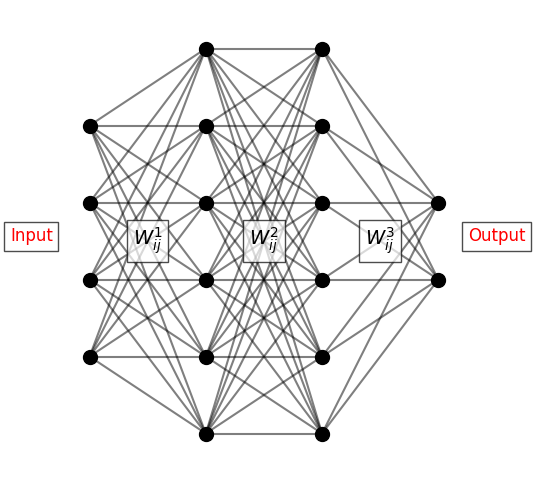

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def draw_fully_connected(ax, layer1, layer2, weight_label, x_offset):
    """Draws connections between two layers and labels them."""
    mid_x = (x_offset + (x_offset + 1)) / 2
    mid_y = (layer1.mean() + layer2.mean()) / 2
    for i, y1 in enumerate(layer1):
        for j, y2 in enumerate(layer2):
            ax.plot([x_offset, x_offset + 1], [y1, y2], 'k-', alpha=0.5)
    ax.text(mid_x, mid_y, weight_label, fontsize=14, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

def plot_nn():
    fig, ax = plt.subplots(figsize=(6, 6))

    # Define layers
    input_layer = np.linspace(4, 1, 4)   # 4 neurons, vertically centered
    hidden_layer1 = np.linspace(5, 0, 6) # 6 neurons
    hidden_layer2 = np.linspace(5, 0, 6) # 6 neurons
    output_layer = np.linspace(3, 2, 2)  # 2 neurons, vertically centered

    # X-coordinates of layers
    x_positions = [0, 1, 2, 3]
    layers = [input_layer, hidden_layer1, hidden_layer2, output_layer]

    # Draw connections
    draw_fully_connected(ax, input_layer, hidden_layer1, '$W^1_{ij}$', x_positions[0])
    draw_fully_connected(ax, hidden_layer1, hidden_layer2, '$W^2_{ij}$', x_positions[1])
    draw_fully_connected(ax, hidden_layer2, output_layer, '$W^3_{ij}$', x_positions[2])

    # Plot neurons
    for x, layer in zip(x_positions, layers):
        ax.scatter([x] * len(layer), layer, s=100, c='black', zorder=3)

    # Labels
    ax.text(-0.5, 2.5, 'Input', fontsize=12, ha='center', c="red", bbox=dict(facecolor='white', alpha=0.7))
    ax.text(3.5, 2.5, 'Output', fontsize=12, ha='center', c="red", bbox=dict(facecolor='white', alpha=0.7))

    # Formatting
    ax.set_xlim(-0.5, 3.5)
    ax.set_ylim(-0.5, 5.5)
    ax.axis('off')

    plt.show()

plot_nn()

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels.  
- You may (as an option) experiment with different optimizers: Adam, AdamW, or other optimizers.  


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.


